In [32]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from clawpack.visclaw.JSAnimation import IPython_display
from time import sleep

In [17]:
def compute_matrices(U,N):
    h=1/(N-1)
    D1=np.diag(np.ones(N-1),-1)-np.diag(np.ones(N-1),1)
    D1*=U/2/h
    
    # MPP artificial viscosity operator #
    DL=D1*0
    for i in range(N):
        for j in np.arange(i+1,N):
            DL[i,j]=np.max([-D1[i,j],0,-D1[j,i]])
            DL[j,i]=DL[i,j]
        DL[i,i]=-np.sum(DL[i,:])
    return D1,DL

In [18]:
def sdisc(u,D1,DL):
    fG = np.dot(D1+DL,u)
    fB = np.dot(-DL,u)
    return fG+fB,fG,fB

In [19]:
def scaled_bad_flux(dt,un,fG,fB,global_bounds=False,single_gamma=False):
    gamma=0*fB
    for i in range(len(fB)):
        # compute bounds 
        if global_bounds:
            umax=1
            umin=0
        else:
            umax=np.max(un[i:i+2]) if i==0 else (np.max(un[i-1:i+1]) if i==len(fB)-1 else np.max(un[i-1:i+2]))
            umin=np.min(un[i:i+2]) if i==0 else (np.min(un[i-1:i+1]) if i==len(fB)-1 else np.min(un[i-1:i+2]))
        # compute limiters 
        gamma_neg = (umin-un[i]-dt*fG[i])/dt/fB[i] if (un[i]+dt*(fG[i]+fB[i])<umin and fB[i]!=0) else 1.0
        gamma_pos = (umax-un[i]-dt*fG[i])/dt/fB[i] if (un[i]+dt*(fG[i]+fB[i])>umax and fB[i]!=0) else 1.0
        gamma[i]=min(gamma_neg,gamma_pos)
    #
    if single_gamma:
        sfB=np.min(gamma)*fB
    else:
        sfB=np.multiply(gamma,fB)
    return sfB

In [ ]:
N=201
x=np.linspace(0,1,N)

global_bounds=False
single_gamma=False

# physical parameters #
U=1
T=0.6
DT=0.1

# Numerical parameters #
h=1./(N-1);
C=0.75
dt=C*h*U

# Initial conditions #
u0=1.0*(x>0.1)*(x<0.2)
un_RK4=1.0*u0;
uLn_RK4=1.0*u0;
un_MRK4=1.0*u0;

(D1,DL)=compute_matrices(U,N)

initial_mass=h*np.sum(u0)

# Time loop #
NT=T/dt
times = np.linspace(0,T,int(NT)+1)
uu_MRK4 = np.zeros([len(u0),int(NT)+1])
i=0
index=1
for t in times:
    # RK4 without stabilization in space
    f1,f1G,f1B=sdisc(un_RK4,D1,DL)
    f2,f2G,f2B=sdisc(un_RK4+0.5*dt*f1,D1,DL)
    f3,f3G,f3B=sdisc(un_RK4+0.5*dt*f2,D1,DL)
    f4,f4G,f4B=sdisc(un_RK4+dt*f3,D1,DL)
    unp1_RK4 = un_RK4 + dt/6.0*(f1+2*f2+2*f3+f4)
    
    # RK4 with stabilization in space 
    f1,f1G,f1B=sdisc(uLn_RK4,D1,DL)
    f2,f2G,f2B=sdisc(uLn_RK4+0.5*dt*f1,D1,DL)
    f3,f3G,f3B=sdisc(uLn_RK4+0.5*dt*f2,D1,DL)
    f4,f4G,f4B=sdisc(uLn_RK4+dt*f3,D1,DL)
    uLnp1_RK4 = uLn_RK4 + dt/6.0*(f1G+2*f2G+2*f3G+f4G)
    
    # MRK4: stabilization in space with limiters
    f1,f1G,f1B=sdisc(un_MRK4,D1,DL)
    f2,f2G,f2B=sdisc(un_MRK4+0.5*dt*f1,D1,DL)
    f3,f3G,f3B=sdisc(un_MRK4+0.5*dt*f2,D1,DL)
    f4,f4G,f4B=sdisc(un_MRK4+dt*f3,D1,DL)
    fG=f1G
    fB=(-5*f1G+2*f2G+2*f3G+f4G)/6.0 + (f1B+2*f2B+2*f3B+f4B)/6.0
    sfB=scaled_bad_flux(dt,un_MRK4,fG,fB,global_bounds=global_bounds,single_gamma=single_gamma)   
    unp1_MRK4 = un_MRK4 + dt*(fG+sfB)

    # update old solution 

min value of (RK4 with low-order stab, RK4 with limiting)= 0.0 -2.5153490401663703e-17


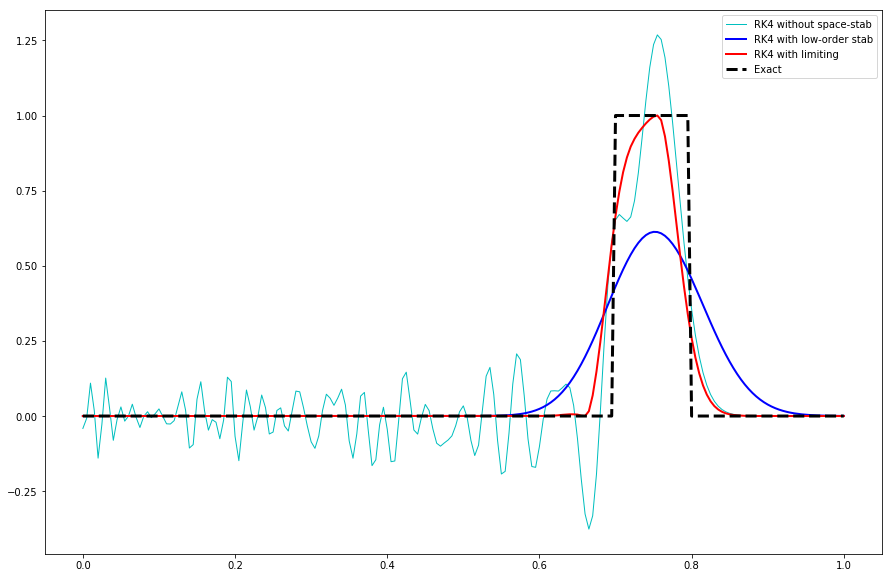

In [63]:
N=201
global_bounds=False
single_gamma=False

# physical parameters #
U=1
T=0.6
DT=0.1
x=np.linspace(0,1,N)

# Numerical parameters #
h=1./(N-1);
C=0.75
dt=C*h*U

# Initial conditions #
u0=1.0*(x>0.1)*(x<0.2)
un_RK4=1.0*u0;
uLn_RK4=1.0*u0;
un_MRK4=1.0*u0;

(D1,DL)=compute_matrices(U,N)

initial_mass=h*np.sum(u0)

# Time loop #
NT=T/dt
times = np.linspace(0,T,int(NT)+1)
uu_MRK4 = np.zeros([len(u0),int(NT)+1])
uuL_RK4 = np.zeros([len(u0),int(NT)+1])
i=0
index=1
for t in times:
    # RK4 without stabilization in space
    f1,f1G,f1B=sdisc(un_RK4,D1,DL)
    f2,f2G,f2B=sdisc(un_RK4+0.5*dt*f1,D1,DL)
    f3,f3G,f3B=sdisc(un_RK4+0.5*dt*f2,D1,DL)
    f4,f4G,f4B=sdisc(un_RK4+dt*f3,D1,DL)
    unp1_RK4 = un_RK4 + dt/6.0*(f1+2*f2+2*f3+f4)
    
    # RK4 with low-order stabilization in space 
    f1,f1G,f1B=sdisc(uLn_RK4,D1,DL)
    f2,f2G,f2B=sdisc(uLn_RK4+0.5*dt*f1G,D1,DL)
    f3,f3G,f3B=sdisc(uLn_RK4+0.5*dt*f2G,D1,DL)
    f4,f4G,f4B=sdisc(uLn_RK4+dt*f3G,D1,DL)
    uLnp1_RK4 = uLn_RK4 + dt/6.0*(f1G+2*f2G+2*f3G+f4G)
    
    # MRK4: stabilization in space with limiters
    f1,f1G,f1B=sdisc(un_MRK4,D1,DL)
    f2,f2G,f2B=sdisc(un_MRK4+0.5*dt*f1,D1,DL)
    f3,f3G,f3B=sdisc(un_MRK4+0.5*dt*f2,D1,DL)
    f4,f4G,f4B=sdisc(un_MRK4+dt*f3,D1,DL)    
    fG=f1G # good flux is given by forward Euler 
    fB=(-5*f1G+2*f2G+2*f3G+f4G)/6.0 + (f1B+2*f2B+2*f3B+f4B)/6.0 # bad flux are the other fluxes
    sfB=scaled_bad_flux(dt,un_MRK4,fG,fB,global_bounds=global_bounds,single_gamma=single_gamma)   
    unp1_MRK4 = un_MRK4 + dt*(fG+sfB)

    # update old solution 
    un_RK4 = unp1_RK4
    uLn_RK4 = uLnp1_RK4
    un_MRK4 = unp1_MRK4

    # save solution for animation 
    uuL_RK4[:,i] = uLnp1_RK4
    uu_MRK4[:,i] = unp1_MRK4

    i+=1
#
loss_LRK4 = (initial_mass - h*np.sum(uLnp1_RK4))/initial_mass
loss_MRK4 = (initial_mass - h*np.sum(unp1_MRK4))/initial_mass

print('min value of (RK4 with low-order stab, RK4 with limiting)=',np.min(uuL_RK4),np.min(unp1_MRK4))
#print('loss in mass of (RK4 with low-order stab, RK4 with limiting)=',loss_LRK4,loss_MRK4)

# plot final solutions #
plt.figure(figsize=([15,10]))
uexact = 1.0*(x-U*t>0.1)*(x-U*t<0.2)
plt.plot(x,unp1_RK4,'-c',linewidth=1)
plt.plot(x,uLnp1_RK4,'-b',linewidth=2)
plt.plot(x,unp1_MRK4,'-r',linewidth=2)
plt.plot(x,uexact,'--k',linewidth=3)
plt.legend(['RK4 without space-stab','RK4 with low-order stab','RK4 with limiting','Exact'])
plt.show()
index+=1